In [2]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.cluster import KMeans #聚类模块
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
df_perf = pd.read_pickle('performance/output/df_performance-win-0924.pkl.zstd', compression='zstd')
df_raf = pd.read_pickle('raf/output/df_raf_final-win-0924.pkl.zstd', compression='zstd')

In [4]:
# join df_perf and df_raf, ignore outer
df_pr = df_perf.join(df_raf, how="inner", lsuffix="_perf", rsuffix="_raf")
df_pr['webgl_time'].fillna(0, inplace=True)
df_pr['status'].value_counts()

status
No WebGL    8664
Ok          6285
Name: count, dtype: int64

In [5]:
df_pr = df_pr[df_pr['status'] == 'Ok']
# df_wtf = df_pr[(df_pr['webgl_time'] == 0) & (df_pr['gpu_full'] > 2)]
# df_wtf.to_json()
# print(df_wtf.loc[29215].to_json())

In [6]:
df_pr_zero = df_pr.drop(columns=['status', 'mem_detail']).fillna(0)

In [7]:
df_pr_zero.columns = [x.replace('maghsk.counter.', '') for x in df_pr_zero.columns]

In [8]:
df_pr_zero.to_pickle('output/df_pr_zero-win-0924.pkl.zstd', compression='zstd')

In [121]:
cmap_colors = [(0, 'red'), (0.5, 'white'), (1, 'green')]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('CustomMap', cmap_colors)

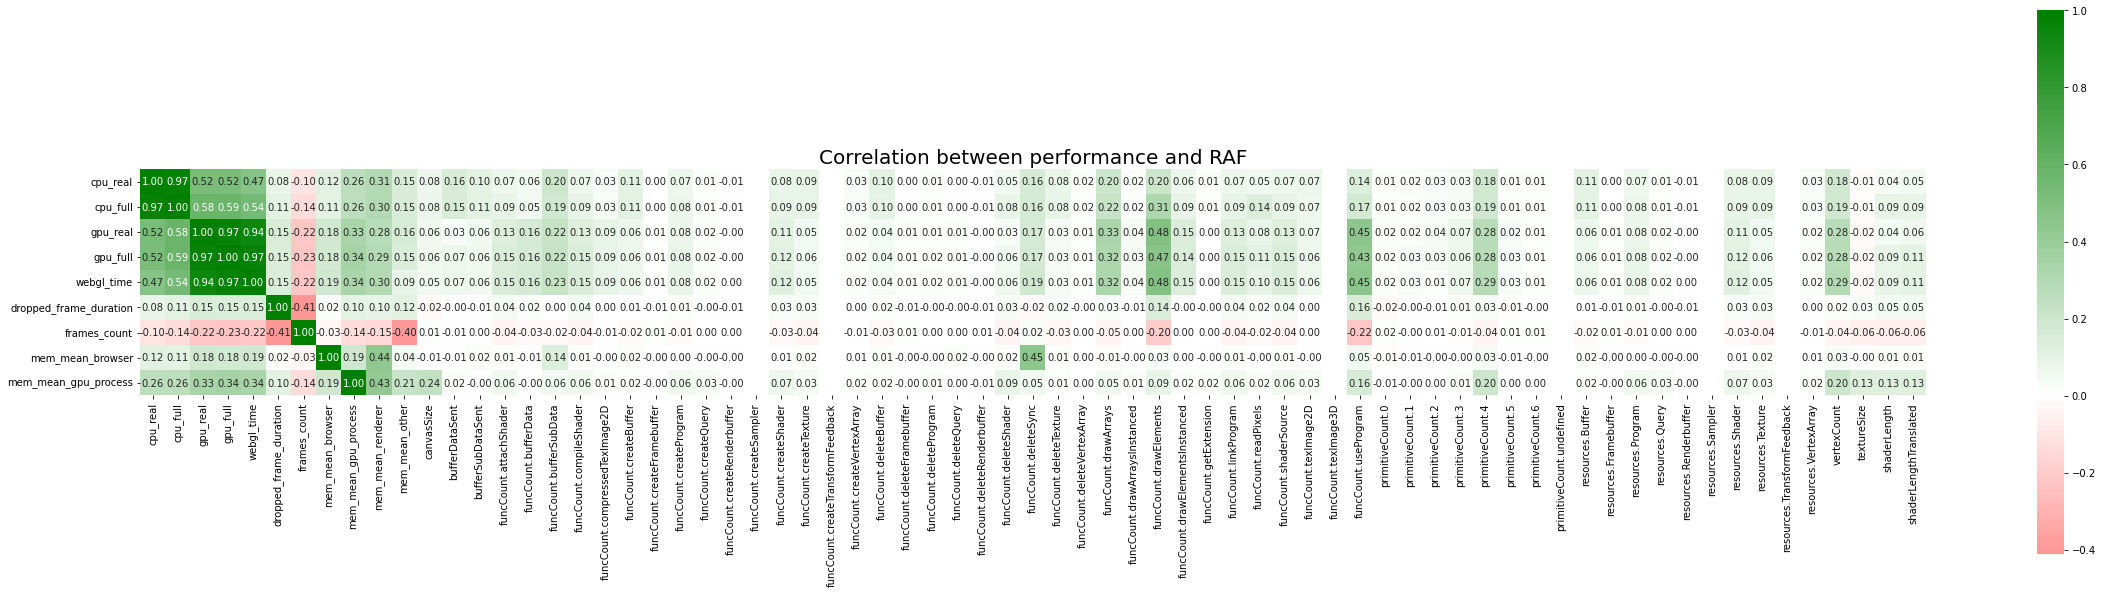

In [122]:
heatmap = df_pr_zero.corr().iloc[:9]
plt.figure(figsize=(40, 10))
ax = sns.heatmap(heatmap, square=True, annot=True, cmap=cmap, fmt='.2f', center=0)
plt.title('Correlation between performance and RAF', fontsize=20)
plt.savefig("output/heatmap.pdf", bbox_inches='tight')

In [123]:
print(*df_pr_zero.columns.to_list(), sep='\n')

cpu_real
cpu_full
gpu_real
gpu_full
webgl_time
dropped_frame_duration
frames_count
mem_mean_browser
mem_mean_gpu_process
mem_mean_renderer
mem_mean_other
canvasSize
bufferDataSent
bufferSubDataSent
funcCount.attachShader
funcCount.bufferData
funcCount.bufferSubData
funcCount.compileShader
funcCount.compressedTexImage2D
funcCount.createBuffer
funcCount.createFramebuffer
funcCount.createProgram
funcCount.createQuery
funcCount.createRenderbuffer
funcCount.createSampler
funcCount.createShader
funcCount.createTexture
funcCount.createTransformFeedback
funcCount.createVertexArray
funcCount.deleteBuffer
funcCount.deleteFramebuffer
funcCount.deleteProgram
funcCount.deleteQuery
funcCount.deleteRenderbuffer
funcCount.deleteShader
funcCount.deleteSync
funcCount.deleteTexture
funcCount.deleteVertexArray
funcCount.drawArrays
funcCount.drawArraysInstanced
funcCount.drawElements
funcCount.drawElementsInstanced
funcCount.getExtension
funcCount.linkProgram
funcCount.readPixels
funcCount.shaderSource
fun

In [141]:
df_pr_hyd = df_pr_zero[[
    'frames_count',
    'cpu_full',
    'cpu_real',
    'gpu_full',
    'gpu_real',
    'webgl_time',
    'dropped_frame_duration',
    'mem_mean_browser',
    'mem_mean_gpu_process',
    'mem_mean_renderer',
    'canvasSize',
    'bufferDataSent',
    'bufferSubDataSent',
    'textureSize',
    'shaderLength',
    'shaderLengthTranslated',
    # 'funcCount.bufferData',
    # 'funcCount.bufferSubData',
    'funcCount.drawArrays',
    'funcCount.drawArraysInstanced',
    'funcCount.drawElements',
    'funcCount.drawElementsInstanced',
    'funcCount.useProgram',
    'vertexCount',
    'primitiveCount.0',
    'primitiveCount.1',
    'primitiveCount.2',
    'primitiveCount.3',
    'primitiveCount.4',
    'primitiveCount.5',
    'primitiveCount.6',
    'resources.Buffer',
    'resources.Framebuffer',
    'resources.Program',
    'resources.Query',
    'resources.Renderbuffer',
    'resources.Sampler',
    'resources.Shader',
    'resources.Texture',
    'resources.TransformFeedback',
    'resources.VertexArray',
]].copy()
df_pr_hyd['shaderLengthTranslated'] -= df_pr_hyd['shaderLength']
df_pr_hyd.drop(columns=['shaderLength'], inplace=True)

# df_pr_hyd['funcCount.bufferData'] += df_pr_hyd['funcCount.bufferSubData']
# df_pr_hyd.drop(columns=['funcCount.bufferSubData'], inplace=True)

In [142]:
df_pr_hyd.to_pickle("output/df_pr_hyd.pkl.zstd", compression="zstd")

In [143]:
from scipy import stats

In [144]:
p_values = pd.DataFrame(index=df_pr_hyd.columns, columns=df_pr_hyd.columns, dtype=float)
r_values = pd.DataFrame(index=df_pr_hyd.columns, columns=df_pr_hyd.columns, dtype=float)

for col1 in df_pr_hyd.columns:
    for col2 in df_pr_hyd.columns:
            r_value, p_value = stats.pearsonr(df_pr_hyd[col1], df_pr_hyd[col2])
            r_values.loc[col1, col2] = r_value
            p_values.loc[col1, col2] = p_value

p_values

/usr/lib/python3/dist-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,frames_count,cpu_full,cpu_real,gpu_full,gpu_real,webgl_time,dropped_frame_duration,mem_mean_browser,mem_mean_gpu_process,mem_mean_renderer,...,resources.Buffer,resources.Framebuffer,resources.Program,resources.Query,resources.Renderbuffer,resources.Sampler,resources.Shader,resources.Texture,resources.TransformFeedback,resources.VertexArray
frames_count,0.000000e+00,6.257393e-29,1.765929e-16,5.421619e-74,7.049684e-71,1.022407e-70,1.440815e-255,7.353537e-03,3.636173e-28,1.835033e-33,...,2.033187e-01,5.227999e-01,2.395805e-01,0.783988,6.940829e-01,NaN,4.012272e-02,5.106420e-04,NaN,6.538412e-01
cpu_full,6.257393e-29,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.884840e-19,1.071500e-18,1.844657e-99,5.041141e-128,...,9.361144e-18,8.640464e-01,2.192673e-09,0.413115,6.347718e-01,NaN,2.027925e-13,1.198860e-12,NaN,2.592414e-02
cpu_real,1.765929e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.674551e-11,5.465628e-20,1.021845e-98,1.244831e-135,...,2.788934e-18,8.474911e-01,4.118059e-08,0.376025,6.088678e-01,NaN,2.244330e-10,1.316835e-13,NaN,2.421987e-02
gpu_full,5.421619e-74,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.068489e-32,9.944563e-45,7.920729e-175,3.010818e-125,...,4.364155e-07,3.827526e-01,2.465586e-11,0.060098,9.045981e-01,NaN,1.496259e-20,1.162753e-05,NaN,7.749341e-02
gpu_real,7.049684e-71,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.994911e-34,2.706095e-49,2.070590e-162,2.175210e-114,...,4.306335e-07,3.897289e-01,5.814163e-10,0.085052,8.450914e-01,NaN,3.096466e-17,1.300102e-05,NaN,8.402122e-02
webgl_time,1.022407e-70,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.327166e-33,1.953521e-51,1.832713e-167,1.580327e-130,...,6.234103e-07,2.908943e-01,2.178951e-11,0.060975,9.821872e-01,NaN,5.953427e-21,2.544973e-05,NaN,5.913889e-02
dropped_frame_duration,1.440815e-255,6.884840e-19,2.674551e-11,1.068489e-32,2.994911e-34,4.327166e-33,0.000000e+00,9.579880e-02,3.355467e-16,6.546861e-15,...,5.865449e-01,5.091963e-01,2.566215e-01,0.774444,6.193960e-01,NaN,4.175510e-02,7.607780e-03,NaN,9.103922e-01
mem_mean_browser,7.353537e-03,1.071500e-18,5.465628e-20,9.944563e-45,2.706095e-49,1.953521e-51,9.579880e-02,0.000000e+00,3.021371e-54,1.312184e-290,...,2.333940e-01,7.814921e-01,8.170695e-01,0.893479,7.830051e-01,NaN,6.605809e-01,2.109835e-01,NaN,6.172560e-01
mem_mean_gpu_process,3.636173e-28,1.844657e-99,1.021845e-98,7.920729e-175,2.070590e-162,1.832713e-167,3.355467e-16,3.021371e-54,0.000000e+00,8.077640e-275,...,1.726783e-01,9.187677e-01,7.665287e-07,0.006679,7.259964e-01,NaN,1.402831e-08,1.544521e-02,NaN,1.444928e-01
mem_mean_renderer,1.835033e-33,5.041141e-128,1.244831e-135,3.010818e-125,2.175210e-114,1.580327e-130,6.546861e-15,1.312184e-290,8.077640e-275,0.000000e+00,...,3.434129e-03,5.322081e-01,6.487587e-05,0.718800,4.041236e-01,NaN,8.604453e-09,9.086923e-07,NaN,3.600681e-01


In [145]:
p_values_mask = p_values < 0.05

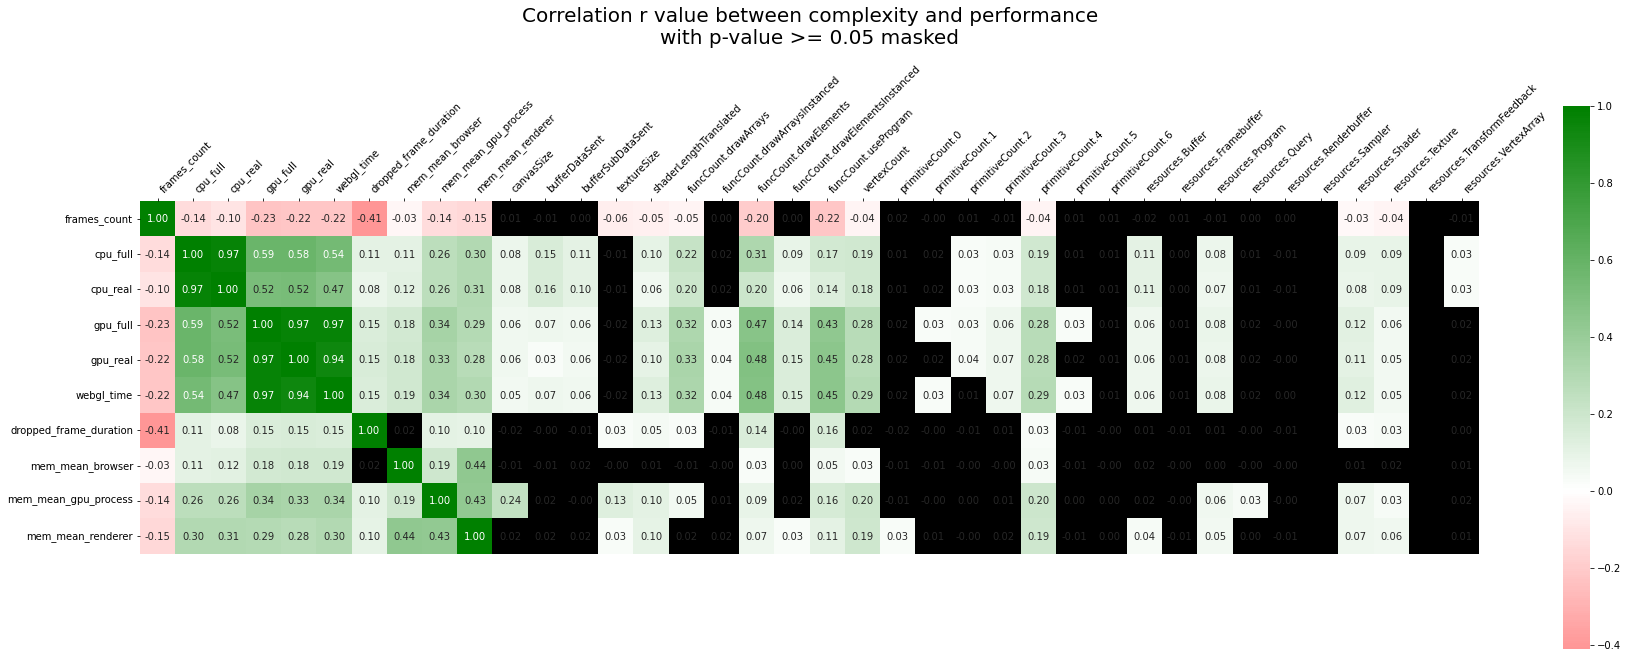

In [148]:
plt.figure(figsize=(30, 10))
ax = sns.heatmap(r_values.iloc[:10], square=True, annot=True, cmap=cmap, fmt='.2f', center=0)
plt.title('Correlation r value between complexity and performance\nwith p-value >= 0.05 masked', fontsize=20, pad=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
for i in range(len(p_values_mask)):
    for j in range(len(p_values_mask)):
        if not p_values_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, lw=0, color='black', alpha=1))
plt.savefig("output/heatmap-rvalue.pdf", bbox_inches='tight')

# clustering

In [132]:
df_pr_hyd = df_pr_zero[[
    'frames_count',
    'cpu_full',
    'gpu_full',
    'webgl_time',
    # 'dropped_frame_duration',
    # 'mem_mean_browser',
    'mem_mean_gpu_process',
    'mem_mean_renderer',
    'canvasSize',
    'bufferDataSent',
    'bufferSubDataSent',
    'textureSize',
    'shaderLength',
    'shaderLengthTranslated',
    # 'funcCount.bufferData',
    # 'funcCount.bufferSubData',
    'funcCount.drawArrays',
    'funcCount.drawArraysInstanced',
    'funcCount.drawElements',
    'funcCount.drawElementsInstanced',
    # 'funcCount.useProgram',
    'vertexCount',
    'primitiveCount.0',
    'primitiveCount.1',
    'primitiveCount.2',
    'primitiveCount.3',
    'primitiveCount.4',
    'primitiveCount.5',
    'primitiveCount.6',
    # 'resources.Buffer',
    # 'resources.Framebuffer',
    # 'resources.Program',
    # 'resources.Query',
    # 'resources.Renderbuffer',
    # 'resources.Sampler',
    # 'resources.Shader',
    # 'resources.Texture',
    # 'resources.TransformFeedback',
    # 'resources.VertexArray',
]].copy()
df_pr_hyd['primitiveCount'] = df_pr_hyd['primitiveCount.0'] + (df_pr_hyd['primitiveCount.1'] + df_pr_hyd['primitiveCount.2'] + df_pr_hyd['primitiveCount.3']) / 2 + (df_pr_hyd['primitiveCount.4'] + df_pr_hyd['primitiveCount.5'] + df_pr_hyd['primitiveCount.6']) / 3
df_pr_hyd.drop(columns=['primitiveCount.0', 'primitiveCount.1', 'primitiveCount.2', 'primitiveCount.3', 'primitiveCount.4', 'primitiveCount.5', 'primitiveCount.6'], inplace=True)
df_pr_hyd['draws'] = df_pr_hyd['funcCount.drawArrays'] + df_pr_hyd['funcCount.drawArraysInstanced'] + df_pr_hyd['funcCount.drawElements'] + df_pr_hyd['funcCount.drawElementsInstanced']
df_pr_hyd.drop(columns=['funcCount.drawArrays', 'funcCount.drawArraysInstanced', 'funcCount.drawElements', 'funcCount.drawElementsInstanced'], inplace=True)
df_pr_hyd['bufferDataSent'] += df_pr_hyd['bufferSubDataSent']
df_pr_hyd.drop(columns=['bufferSubDataSent'], inplace=True)
df_pr_hyd['shaderLengthTranslated'] -= df_pr_hyd['shaderLength']
df_pr_hyd.drop(columns=['shaderLength'], inplace=True)

# df_pr_hyd['funcCount.bufferData'] += df_pr_hyd['funcCount.bufferSubData']
# df_pr_hyd.drop(columns=['funcCount.bufferSubData'], inplace=True)

In [133]:
df_pr_hyd = df_pr_zero[[
    'frames_count',
    'cpu_full',
    'gpu_full',
    'webgl_time',
    # 'dropped_frame_duration',
    # 'mem_mean_browser',
    'mem_mean_gpu_process',
    'mem_mean_renderer',
    'canvasSize',
    'bufferDataSent',
    'bufferSubDataSent',
    'textureSize',
    'shaderLength',
    'shaderLengthTranslated',
    # 'funcCount.bufferData',
    # 'funcCount.bufferSubData',
    'funcCount.drawArrays',
    'funcCount.drawArraysInstanced',
    'funcCount.drawElements',
    'funcCount.drawElementsInstanced',
    # 'funcCount.useProgram',
    'vertexCount',
    'primitiveCount.0',
    'primitiveCount.1',
    'primitiveCount.2',
    'primitiveCount.3',
    'primitiveCount.4',
    'primitiveCount.5',
    'primitiveCount.6',
    # 'resources.Buffer',
    # 'resources.Framebuffer',
    # 'resources.Program',
    # 'resources.Query',
    # 'resources.Renderbuffer',
    # 'resources.Sampler',
    # 'resources.Shader',
    # 'resources.Texture',
    # 'resources.TransformFeedback',
    # 'resources.VertexArray',
]].copy()
df_pr_hyd['primitiveCount'] = df_pr_hyd['primitiveCount.0'] + (df_pr_hyd['primitiveCount.1'] + df_pr_hyd['primitiveCount.2'] + df_pr_hyd['primitiveCount.3']) / 2 + (df_pr_hyd['primitiveCount.4'] + df_pr_hyd['primitiveCount.5'] + df_pr_hyd['primitiveCount.6']) / 3
df_pr_hyd.drop(columns=['primitiveCount.0', 'primitiveCount.1', 'primitiveCount.2', 'primitiveCount.3', 'primitiveCount.4', 'primitiveCount.5', 'primitiveCount.6'], inplace=True)
df_pr_hyd['draws'] = df_pr_hyd['funcCount.drawArrays'] + df_pr_hyd['funcCount.drawArraysInstanced'] + df_pr_hyd['funcCount.drawElements'] + df_pr_hyd['funcCount.drawElementsInstanced']
df_pr_hyd.drop(columns=['funcCount.drawArrays', 'funcCount.drawArraysInstanced', 'funcCount.drawElements', 'funcCount.drawElementsInstanced'], inplace=True)
df_pr_hyd['bufferDataSent'] += df_pr_hyd['bufferSubDataSent']
df_pr_hyd.drop(columns=['bufferSubDataSent'], inplace=True)
df_pr_hyd['shaderLengthTranslated'] -= df_pr_hyd['shaderLength']
df_pr_hyd.drop(columns=['shaderLength'], inplace=True)

# df_pr_hyd['funcCount.bufferData'] += df_pr_hyd['funcCount.bufferSubData']
# df_pr_hyd.drop(columns=['funcCount.bufferSubData'], inplace=True)

In [134]:
# normalization
std = df_pr_hyd.std(axis=0)
mean = df_pr_hyd.mean(axis=0)
df_scaled = (df_pr_hyd - mean) / std
df_scaled.fillna(0, inplace=True)


# # 0~1
# min = df_pr_hyd.min(axis=0)
# max = df_pr_hyd.max(axis=0)
# df_scaled = (df_pr_hyd - min) / (max - min)
# df_scaled.fillna(0, inplace=True)

In [135]:
SSE = []
SCORE = []
RANGE = range(2, 11)
for clusters in RANGE:
    km = KMeans(n_clusters=clusters, n_init='auto', random_state=42, max_iter=1000, tol=1e-7).fit(df_scaled)
    SSE.append(km.inertia_)
    score = silhouette_score(df_scaled, km.labels_, random_state=42)
    SCORE.append(score)
SSE = np.array(SSE)
SCORE = np.array(SCORE)

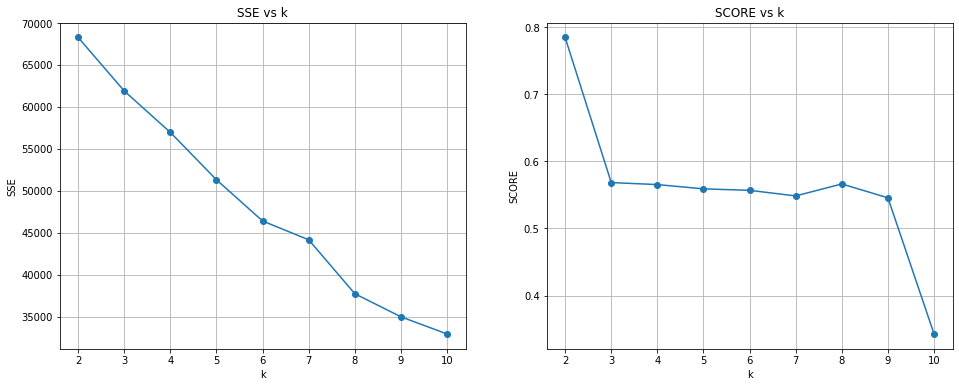

In [136]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(RANGE, SSE, 'o-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.title('SSE vs k')
plt.subplot(1, 2, 2)
plt.plot(RANGE, SCORE, 'o-')
plt.xlabel('k')
plt.ylabel('SCORE')
plt.grid(True)
plt.title('SCORE vs k')
plt.savefig("output/kmeans.pdf", bbox_inches='tight')

In [137]:
n_clusters = 8
km = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42, max_iter=1000).fit(df_scaled)
# df_pr_hyd['cluster'] = km.labels_
center = km.cluster_centers_
# real_center = scaler.inverse_transform(center)
real_center = center * std.values + mean.values
labels = km.labels_
num = pd.Series(labels).value_counts().sort_index().astype(str)
r = pd.concat([num, pd.DataFrame(real_center)], axis=1)
r.columns = ['num'] + list(df_pr_hyd.columns)
center_min = center.min(axis=0)
center_max = center.max(axis=0)
center_scale = (center - center_min) / (center_max - center_min)

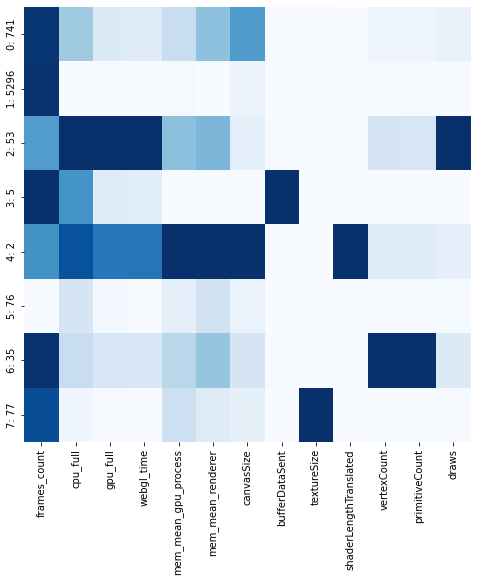

In [138]:
plt.figure(figsize=(8, 8))
sns.heatmap( center_scale, square=False, annot=False, cbar=False, fmt='.2f', cmap='Blues', yticklabels=['{}: {}'.format(x,y) for x, y in zip(num.index, num.values)], xticklabels=df_scaled.columns, vmax=1,vmin=0, ) # type: ignore
plt.savefig('./output/heatmap-2.pdf', bbox_inches='tight')